In [50]:
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt  # matplotlib is not installed automatically
%matplotlib inline
import pandas as pd

#####

main_path = '/storage/coda1/p-rbras6/0/njadidoleslam3/sensor_sm'

# Either a .zip file or one folder that contains all networks, here we read from .zip
ismn_data = ISMN_Interface(main_path,network=['USCRN'])

Found existing ismn metadata in /storage/coda1/p-rbras6/0/njadidoleslam3/sensor_sm/python_metadata/sensor_sm.csv.


In [71]:
sensor_meta_all = []

variables = ['station', 'network', 'latitude', 'longitude', 'timerange_from', 'timerange_to','climate_KG', 'instrument']
for network, station, sensor in ismn_data.collection.iter_sensors(variable='soil_moisture', depth=[0., 0.05]):
    _sensor_meta = sensor.metadata.to_pd()
    sensor_meta_all.append(list(_sensor_meta[variables].values[:-2]))
    
# display(station)

In [208]:
len(sensor_meta_all)

115

In [110]:
import geopandas as gpd
import matplotlib.pyplot as plt
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# conus = gpd.read_file('/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/gis_files/conus/cb_2018_us_nation_5m_CRS4326.shp').to_crs(epsg=3857)
conus = gpd.read_file('/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/gis_files/conus/cb_2018_us_state_5m.shp').to_crs(epsg=3857)
fn_us_states = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/gis_files/conus/conus_states.geojson'
us_states = gpd.read_file(fn_us_states)
us_states = us_states.to_crs(4326)


In [113]:
sensor_meta_all = pd.DataFrame(sensor_meta_all, columns=variables)
sensors_gpd = gdf = gpd.GeoDataFrame(sensor_meta_all, geometry=gpd.points_from_xy(sensor_meta_all.longitude, sensor_meta_all.latitude)).set_crs(epsg=4326)

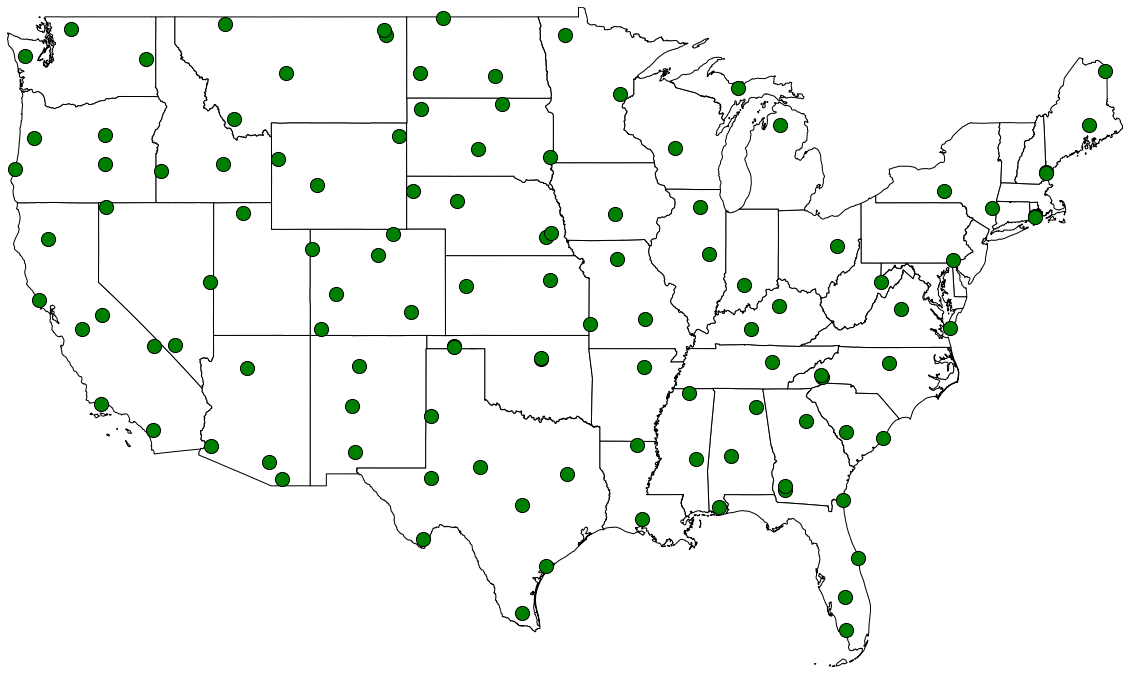

In [140]:

xlim = ([us_states.total_bounds[0],  us_states.total_bounds[2]])
ylim = ([us_states.total_bounds[1],  us_states.total_bounds[3]])


fig, ax = plt.subplots(figsize = (20,15))
us_states.plot(ax=ax, color='white', edgecolor='black')
sensors_gpd.plot(ax=ax, markersize=200, color='green', edgecolor='black')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_axis_off()

# Data analysis

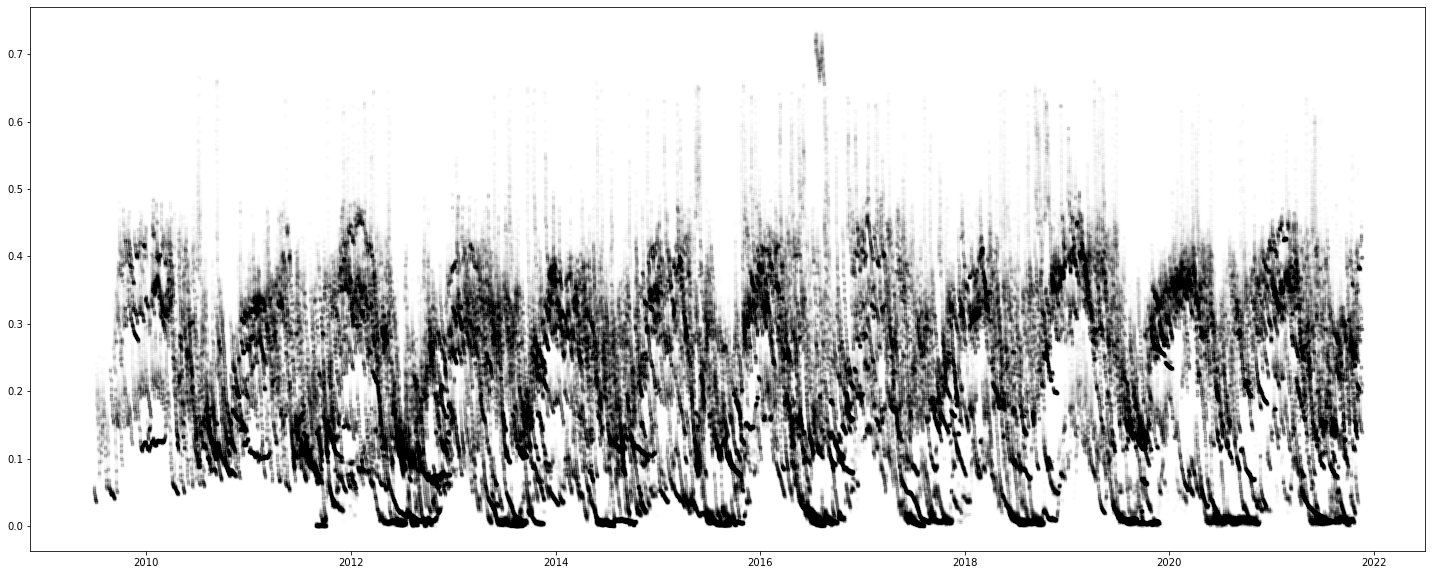

In [131]:
ii = 0
fig, ax = plt.subplots(figsize = (25,10))
for network, station, sensor in ismn_data.collection.iter_sensors(variable='soil_moisture', depth=[0., 0.05]):
    data = sensor.read_data()
    ax.plot(data.index, data['soil_moisture'], linestyle='', marker='.', alpha = 0.01, color='black')
    ii +=1
    if ii>10:
        break

In [170]:
daily_data = data.resample('D').mean()

In [206]:
mean_sm = dict()
sd_sm = dict()
for stage in [4,5,6]:
    mean_sm[stage] = dict()
    sd_sm[stage] = dict()
    for ds in range(1,5):
        mean_sm[stage][ds] = []
        sd_sm[stage][ds] = []
        days_lead = daily_data.index + pd.Timedelta(10*ds, 'd')
        for init in np.arange(0.05, 0.5, 0.05):
            idx = (daily_data['soil_moisture']>=init) & (daily_data['soil_moisture']<init+0.05) & (daily_data.index.month==stage) 
            mask = np.in1d(daily_data.index,days_lead)
            sm_vec = daily_data['soil_moisture'][mask & idx]
            mean_sm[stage][ds].append((init, np.nanmean(sm_vec)))
            sd_sm[stage][ds].append((init, np.nanstd(sm_vec)))
        mean_sm[stage][ds] = np.array(mean_sm[stage][ds])
        sd_sm[stage][ds] = np.array(sd_sm[stage][ds])

/tmp/ipykernel_109924/1839680900.py:14: RuntimeWarning: Mean of empty slice
  mean_sm[stage][ds].append((init, np.nanmean(sm_vec)))


In [207]:
mean_sm

{4: {1: array([[0.05      , 0.07375735],
         [0.1       , 0.12451531],
         [0.15      , 0.1742353 ],
         [0.2       , 0.21640168],
         [0.25      ,        nan],
         [0.3       ,        nan],
         [0.35      ,        nan],
         [0.4       ,        nan],
         [0.45      ,        nan]]),
  2: array([[0.05      , 0.07375735],
         [0.1       , 0.12451531],
         [0.15      , 0.1742353 ],
         [0.2       , 0.21640168],
         [0.25      ,        nan],
         [0.3       ,        nan],
         [0.35      ,        nan],
         [0.4       ,        nan],
         [0.45      ,        nan]]),
  3: array([[0.05      , 0.07375735],
         [0.1       , 0.12451531],
         [0.15      , 0.1742353 ],
         [0.2       , 0.21640168],
         [0.25      ,        nan],
         [0.3       ,        nan],
         [0.35      ,        nan],
         [0.4       ,        nan],
         [0.45      ,        nan]]),
  4: array([[0.05      , 0.07375735],

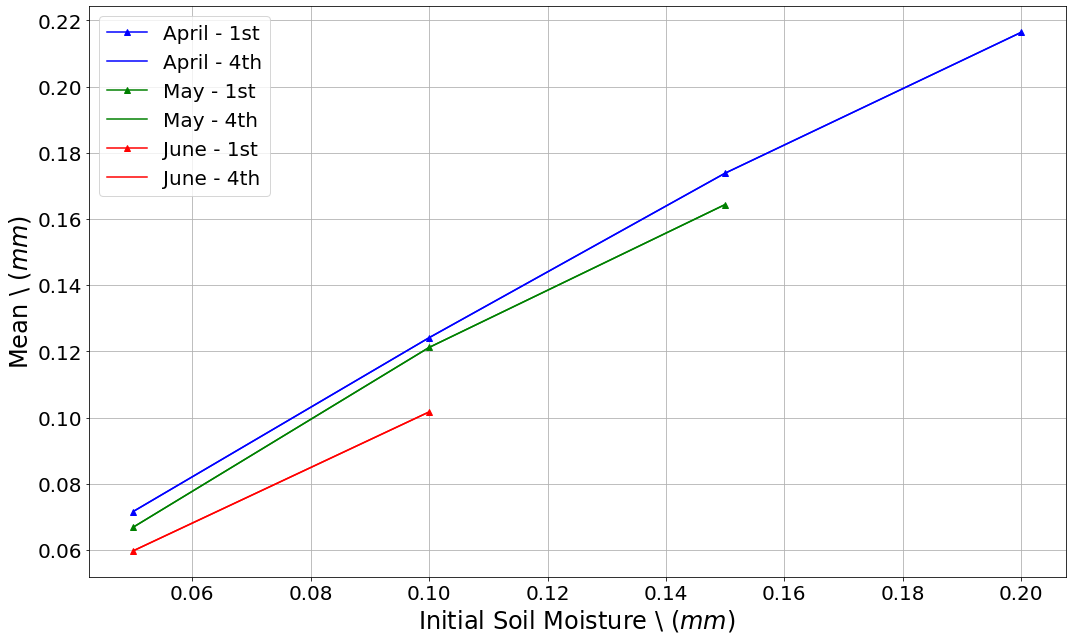

In [202]:
fig,ax = plt.subplots(figsize=(15, 9))
ax.tick_params(labelsize = 20)
ax.set_ylabel(r'Mean \ ($mm$)', fontsize = 24)
ax.set_xlabel(r'Initial Soil Moisture \ ($mm$)', fontsize = 24)
ax.tick_params(labelsize = 20)
plt.plot(mean_sm[4][1][:,0],mean_sm[4][1][:,1], color='blue', marker='^', label = 'April - 1st')
plt.plot(mean_sm[4][4][:,0],mean_sm[4][4][:,1], color='blue', label = 'April - 4th')
plt.plot(mean_sm[5][1][:,0],mean_sm[5][1][:,1], color='g', marker='^',label = 'May - 1st')
plt.plot(mean_sm[5][4][:,0],mean_sm[5][4][:,1], color='g', label = 'May - 4th')
plt.plot(mean_sm[6][1][:,0],mean_sm[6][1][:,1], color='red', marker='^', label = 'June - 1st')
plt.plot(mean_sm[6][4][:,0],mean_sm[6][4][:,1], color='red', label = 'June - 4th')
ax.grid('major')
ax.legend(fontsize=20)
# ax.set_ylim([0,])
fig.tight_layout()
# fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/mean_sm_hourly.jpg', dpi=300)

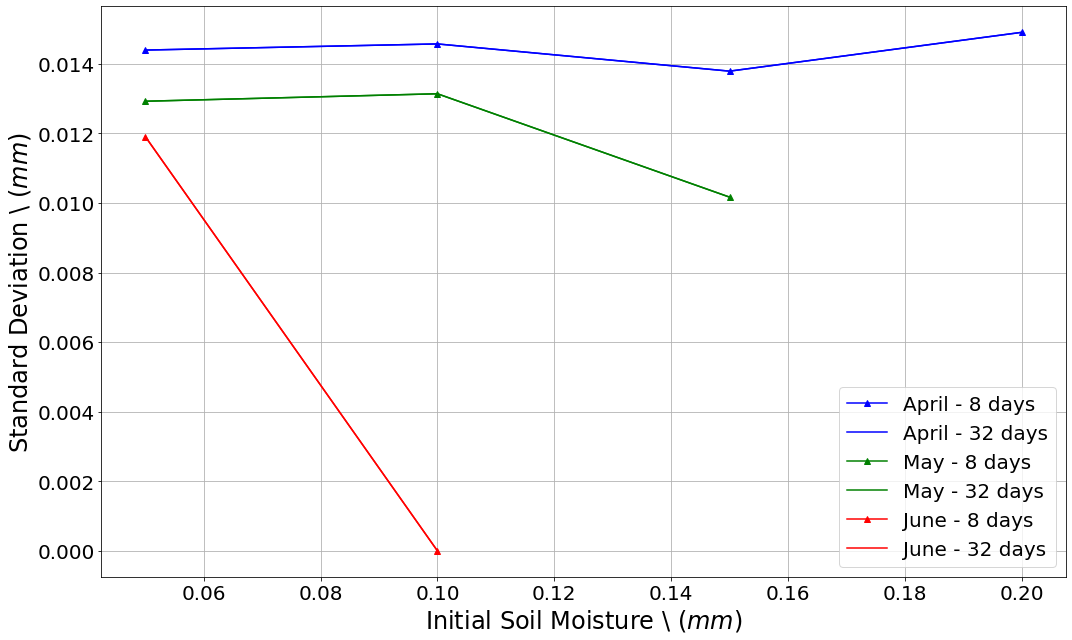

In [203]:

fig,ax = plt.subplots(figsize=(15, 9))
ax.tick_params(labelsize = 20)
ax.set_ylabel(r'Standard Deviation \ ($mm$)', fontsize = 24)
ax.set_xlabel(r'Initial Soil Moisture \ ($mm$)', fontsize = 24)
ax.tick_params(labelsize = 20)
plt.plot(sd_sm[4][1][:,0],sd_sm[4][1][:,1], color='blue', marker='^', label = 'April - 8 days')
plt.plot(sd_sm[4][4][:,0],sd_sm[4][4][:,1], color='blue', label = 'April - 32 days')
plt.plot(sd_sm[5][1][:,0],sd_sm[5][1][:,1], color='g', marker='^',label = 'May - 8 days')
plt.plot(sd_sm[5][4][:,0],sd_sm[5][4][:,1], color='g', label = 'May - 32 days')
plt.plot(sd_sm[6][1][:,0],sd_sm[6][1][:,1], color='red', marker='^', label = 'June - 8 days')
plt.plot(sd_sm[6][4][:,0],sd_sm[6][4][:,1], color='red', label = 'June - 32 days')
ax.grid('major')
ax.legend(fontsize=20)
fig.tight_layout()
# fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/sd_sm_hourly.jpg', dpi=300)

In [ ]:
from ismember import ismember

a, b = ismember(daily_data.index,ten_day_lead,method='elementwise')

In [193]:
mask = np.in1d(daily_data.index,ten_day_lead)
mask & idx

ValueError: operands could not be broadcast together with shapes (3715,) (86867,) 

In [ ]:
mean_sm = dict()
sd_sm = dict()
for stage in [4,5,6]:
    mean_sm[stage] = dict()
    sd_sm[stage] = dict()
    for ds in range(1,5):
        mean_sm[stage][ds] = []
        sd_sm[stage][ds] = []
        for init in np.arange(0, 0.5, 0.05):
            idx = (results_all[stage][5]==init) & (results_all[stage][3].dt.dayofyear==(152-(6-stage)*30)+ds*8) & (results_all[stage][3].dt.hour==1)

            mean_sm[stage][ds].append((init, np.mean(results_all[stage].loc[idx][1])))
            sd_sm[stage][ds].append((init, np.std(results_all[stage].loc[idx][1])))

        mean_sm[stage][ds] = np.array(mean_sm[stage][ds])
        sd_sm[stage][ds] = np.array(sd_sm[stage][ds])

In [ ]:
# variable = 'tb'
from matplotlib import ticker

xlim = ([us_states.total_bounds[0],  us_states.total_bounds[2]])
ylim = ([us_states.total_bounds[1],  us_states.total_bounds[3]])

pickle_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/stage4_analysis/summary/{month}_new.pickle'

for month in [7]:#range(1,13):
    in_pickle = pickle_fmt.format(month = month)
    summary = read_pickle(in_pickle)
    summary = summary[0]
    summary['grid_xy'] = summary['grid_xy'].astype(np.int64)
    data = st4_grid_masked.merge(summary)
    for variable in ['tr']:#list(var_list.keys()):
            


        out_pth = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/figures/st4/summary/{variable}/'.format(variable = variable)
        out_fn = '{variable}_{month}_new1.jpg'.format(variable = variable, month=month)

        if not os.path.exists(out_pth):
            os.makedirs(out_pth)

        fn_temp = '{variable}.png'
        cm1 = plt.cm.get_cmap(var_list[variable]['cmap'],var_list[variable]['nbins']-0)
        fig, ax = plt.subplots(figsize=(20, 16))

        a = data.plot(ax=ax, column=variable, edgecolor='none', cmap=cm1, vmin = var_list[variable]['min'], vmax=var_list[variable]['max'], zorder = 0)
        us_states.plot(ax=ax, facecolor="none", edgecolor="black", zorder = 1, alpha=0.2)
        
        ax.set_axis_off()
        dt_str = '2020-{month}-1'.format(month = month)
        mnth_name = pd.to_datetime(dt_str).month_name()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.text(0.42,-0.03, mnth_name,transform=ax.transAxes, fontsize=30)
        cax = fig.add_axes([0.1, 0.15, 0.8, 0.04])
        fig.colorbar( a.collections[0], cax=cax, orientation='horizontal')
        cax.set_xlabel(var_list[variable]['label'], fontsize=20)

        cax.tick_params(labelsize=18)
        
        x_d = np.linspace(var_list[variable]['min'], var_list[variable]['max'], var_list[variable]['nbins']+1)
        
        labels = []
        for i,x in enumerate(x_d):
            if i%2==0:
                if variable in ['tb', 'tr', 'count']:
                    labels.append(str(int(x)))
                else:
                    labels.append(str(x))
            else:
                labels.append('')


        cax.xaxis.set_major_locator(ticker.FixedLocator(x_d))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
        # cax.set_xticks(x_d)
        # cax.set_xticklabels([str(x) for x in x_d])
        fn_out = os.path.join(out_pth,out_fn)
        fig.savefig(fn_out, dpi=300, bbox_inches='tight')
        plt.close(fig)

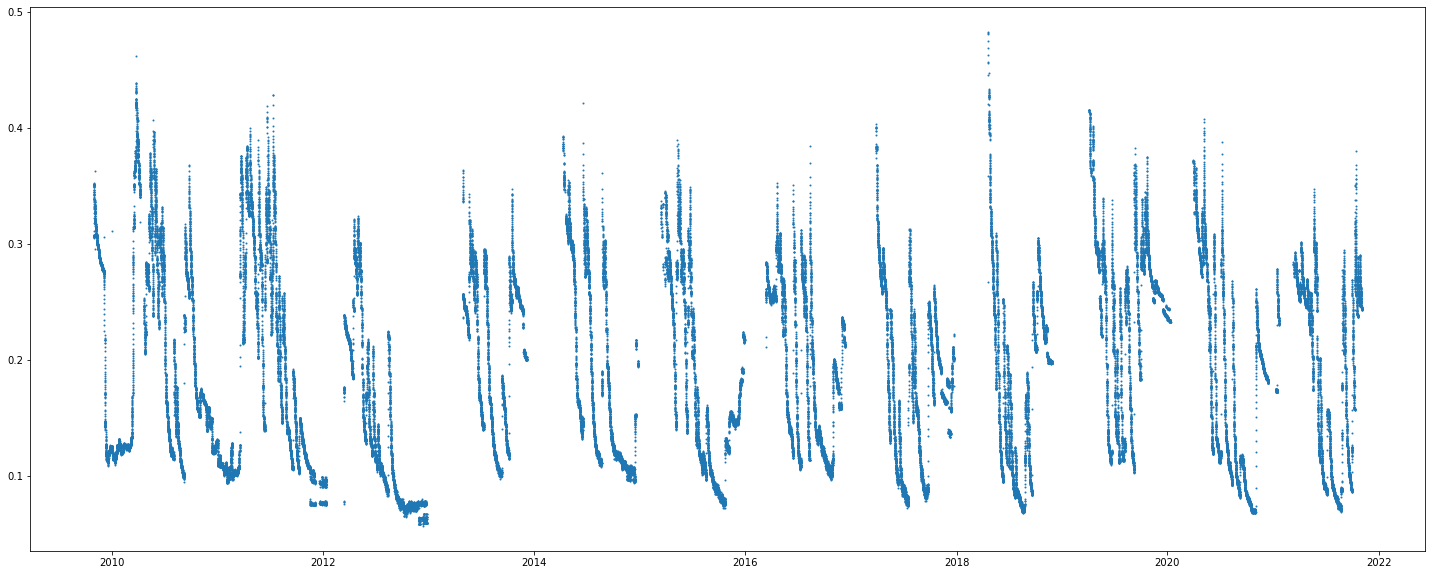

In [18]:
fig, ax = plt.subplots(figsize=(25,10))
ax.scatter(data.index, data['soil_moisture'], s = 1)